In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
# warnings.filterwarnings('error', message="")

In [4]:
import jax
import jax.numpy as np

from flax.core.frozen_dict import freeze, FrozenDict
from jax.flatten_util import ravel_pytree
from jax.tree_util import register_pytree_node_class
import jax.experimental.optimizers as optimizers
from tqdm.auto import tqdm
import copy

from contextlib import contextmanager

@register_pytree_node_class
class Model:
    def __init__(self, a=1.0, b=2.0, c=3.0):
        self.a = a
        self.b = b
        self.c = c
    
    @property
    def _hyperparameters(self):
        return freeze(dict(c=self.c))
    
    @_hyperparameters.setter
    def _hyperparameters(self, hyperparams):
        self.c = hyperparams["c"]
        
    @property
    def _parameters(self):
        return freeze(dict(a=self.a, b=self.b))
    
    @_parameters.setter
    def _parameters(self, params):
        self.a = params["a"]
        self.b = params["b"]
        
    def tree_flatten(self):
        children = (self._parameters, self._hyperparameters)
        aux_data = None
        return children, aux_data
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        params, hypers = children
        return cls(**params, c=hypers)
    
    @contextmanager
    def inject(self, new_parameters):
        old_parameters = copy.deepcopy(self._parameters)
        self._parameters = new_parameters
        yield self
        self._parameters = old_parameters
    
    def loss(self, data):
            return ((self.a - data[0])**2 + 
                    (self.b - data[1])**2 + 
                    (self.c - data[2])**2)        
        
    def fit(self, data):
        
        init_fn, update_fn, get_params = optimizers.adam(1e-3)
        opt_state = init_fn(self._parameters)

        # OPTION 1
        # def objective(params):
        #     self._parameters = params
        #     return self.loss(data)
        
        # OPTION 2
        def objective(params):
            with self.inject(params):
                return self.loss(data)
        
        @jax.jit
        def step(idx, opt_state):
            value, grads = jax.value_and_grad(objective)(get_params(opt_state))
            opt_state = update_fn(idx, grads, opt_state)
            return value, opt_state
        
        losses = []
        for idx in tqdm(range(10000)):
            value, opt_state = step(idx, opt_state)
            losses.append(value)
            
        self._parameters = get_params(opt_state)
        return losses

In [5]:
from ssm.hmm.emissions import GaussianEmissions
dist = GaussianEmissions(5, np.ones((5,)), np.ones((5, 5)))


In [6]:
def get_unconstrained_parameters(dist, dtype=np.float32):
    
    out = {}
    parameter_properties = dist.parameter_properties(dtype)
    
    for parameter_key in dist.parameters:
        param = dist.parameters[parameter_key]
        if param is not None and parameter_key in parameter_properties:
            prop = parameter_properties[parameter_key]
            out[parameter_key] = prop.default_constraining_bijector_fn().inverse(param)
        
    return out

def from_unconstrained_parameters(dist_cls, unconstrained_parameters, dtype=np.float32):
    
    out = {}
    parameter_properties = dist_cls.parameter_properties(dtype)
    
    for parameter_key in unconstrained_parameters:
        param = unconstrained_parameters[parameter_key]
        prop = parameter_properties[parameter_key]
        out[parameter_key] = prop.default_constraining_bijector_fn().forward(param)
        
    return dist_cls(**out)

In [7]:
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions.MultivariateNormalFullCovariance(loc=np.arange(5, dtype=np.float32), covariance_matrix=np.identity(5))

unconstrained_params = get_unconstrained_parameters(dist)
dist = from_unconstrained_parameters(tfp.distributions.MultivariateNormalFullCovariance, 
                                     unconstrained_params)

In [78]:
dist._parameter_properties(np.float32)

{'loc': ParameterProperties(event_ndims=1, event_ndims_tensor=1, shape_fn=<function ParameterProperties.<lambda> at 0x14f441790>, default_constraining_bijector_fn=<function _default_constraining_bijector_fn at 0x14f4411f0>, is_preferred=True, is_tensor=True, specifies_shape=False),
 'covariance_matrix': ParameterProperties(event_ndims=2, event_ndims_tensor=2, shape_fn=<function MultivariateNormalFullCovariance._parameter_properties.<locals>.<lambda> at 0x297cbfee0>, default_constraining_bijector_fn=<function MultivariateNormalFullCovariance._parameter_properties.<locals>.<lambda> at 0x297c70af0>, is_preferred=True, is_tensor=True, specifies_shape=False)}

In [79]:

bijector = dist._parameter_properties(np.float32)["covariance_matrix"].default_constraining_bijector_fn()
bijector.inverse(dist.parameters["covariance_matrix"])

DeviceArray([0.5413246, 0.       , 0.       , 0.       , 0.       ,
             0.5413246, 0.5413246, 0.       , 0.       , 0.       ,
             0.       , 0.5413246, 0.5413246, 0.       , 0.       ],            dtype=float32)

FrozenDict({
    a: 1.0,
    b: 2.0,
})


100%|██████████| 10000/10000 [00:00<00:00, 56092.18it/s]

FrozenDict({
    a: DeviceArray(4.9999785, dtype=float32),
    b: DeviceArray(9.645768, dtype=float32),
})


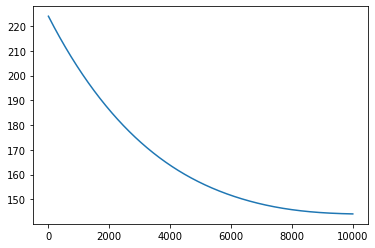

In [80]:
model = Model()

print(model._parameters)
losses = model.fit(np.array([5., 10., 15.,]))
print(model._parameters)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [81]:
@jax.jit
def identity(model):
    return model

identity(model)

In [82]:
model._parameters

FrozenDict({
    a: DeviceArray(4.9999785, dtype=float32),
    b: DeviceArray(9.645768, dtype=float32),
})

In [83]:
model._hyperparameters

FrozenDict({
    c: 3.0,
})

In [84]:
flattened, unflatten_fn = ravel_pytree(model._parameters)
print(flattened)

[4.9999785 9.645768 ]


In [14]:
model = Model()

print(model._parameters)

with model.inject(new_parameters={"a": 10., "b": 20.}):
    print("injected params in this scope: ", model._parameters)

print("old params are preserved: ", model._parameters)

FrozenDict({
    a: 1.0,
    b: 2.0,
})
injected params in this scope:  FrozenDict({
    a: 10.0,
    b: 20.0,
})
old params are preserved:  FrozenDict({
    a: 1.0,
    b: 2.0,
})


# Testing with an HMM

In [8]:
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

from ssm.hmm import GaussianHMM
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation
import warnings

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()
    
def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes([axs[1].get_position().x1 + 0.07,
                        axs[1].get_position().y0,
                        0.02,
                        axs[1].get_position().y1-axs[1].get_position().y0])
    plt.colorbar(out, cax=cax)
    plt.show()

def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()
    
def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), '--', label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()

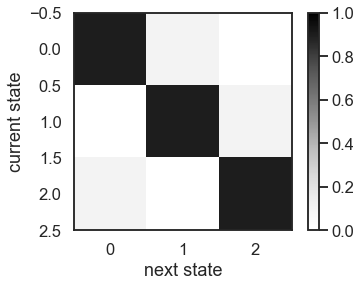

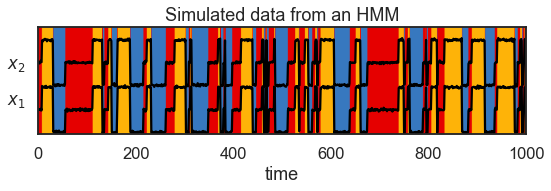

In [9]:
# define some parameters
num_states = 3
num_emission_dims = 2

transition_matrix = 0.9 * np.eye(num_states) \
                    + 0.1 * np.roll(np.eye(num_states), 1, axis=1)

emission_means = np.arange(6, dtype=float).reshape((3, 2)) - 3
emission_covariance=0.25**2 * np.eye(num_emission_dims)

# create the model
true_hmm = GaussianHMM(
    num_states=num_states, 
    num_emission_dims=num_emission_dims,
    transition_matrix=transition_matrix,
    emission_means=emission_means,
    emission_covariances=emission_covariance)

# sample latent states, observations (data) from the model
num_timesteps = 1000
states, data = true_hmm.sample(jr.PRNGKey(0), num_timesteps, num_samples=32)

# view the sampled data
plot_transition_matrix(transition_matrix)
plot_hmm_data(data[0], states[0])

In [10]:
true_hmm._parameters

FrozenDict({
    initial_condition: {
        logits: DeviceArray([-1.0986123, -1.0986123, -1.0986123], dtype=float32),
    },
    transitions: {
        logits: DeviceArray([[-0.10536055, -2.3025851 ,        -inf],
                     [       -inf, -0.10536055, -2.3025851 ],
                     [-2.3025851 ,        -inf, -0.10536055]], dtype=float32),
    },
    emissions: {
        loc: DeviceArray([[-3., -2.],
                     [-1.,  0.],
                     [ 1.,  2.]], dtype=float32),
        scale_tril: DeviceArray([-2.741178,  0.      , -2.741178], dtype=float32),
    },
})

In [11]:
true_hmm._transitions._distribution.probs_parameter()

DeviceArray([[0.9       , 0.09999999, 0.        ],
             [0.        , 0.9       , 0.09999999],
             [0.09999999, 0.        , 0.9       ]], dtype=float32)

In [12]:
# we initialize a random HMM which we will fit to our data
seed = jr.PRNGKey(3)
num_states_est = 3

test_hmm = GaussianHMM(num_states=num_states, num_emission_dims=num_emission_dims, seed=seed)

In [13]:
test_hmm.marginal_likelihood(data).mean()

DeviceArray(-4135.6357, dtype=float32)

In [15]:
from jax.experimental.optimizers import adam
from jax import jit, value_and_grad

opt = adam(1e-3)
opt_state = opt.init_fn(test_hmm._parameters)

def loss(parameters):
    with test_hmm.inject(parameters):
        lp = test_hmm.marginal_likelihood(data).mean()
    return -1 * lp

@jit
def update(step_idx, opt_state):
    f = value_and_grad(loss)
    neg_lp, grads = f(opt.params_fn(opt_state))
    opt_state = opt.update_fn(step_idx, grads, opt_state)
    return opt_state, -1 * neg_lp

from tqdm.auto import trange

lps = []
for i in trange(5000):
    opt_state, lp = update(i, opt_state)
    lps.append(lp)

100%|██████████| 5000/5000 [00:14<00:00, 344.19it/s]


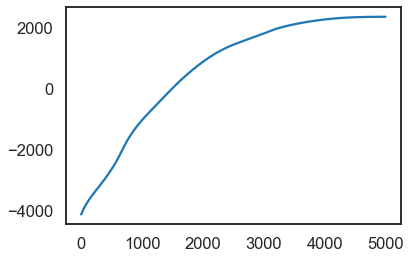

In [16]:
plt.plot(lps)
plt.show()

In [17]:
fitted_params = opt.params_fn(opt_state)

In [18]:
fitted_hmm = test_hmm
fitted_hmm._parameters = fitted_params

### Let's inspect the fitted model

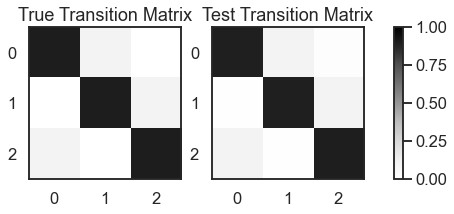

In [19]:
# Here, we compare the true and inferred transition matrix
compare_transition_matrix(true_hmm.transition_matrix, fitted_hmm.transition_matrix)

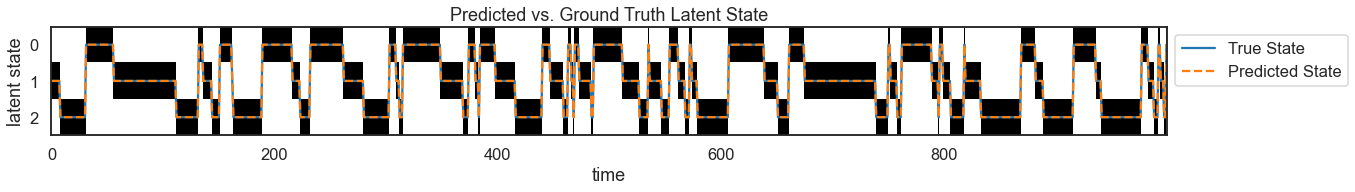

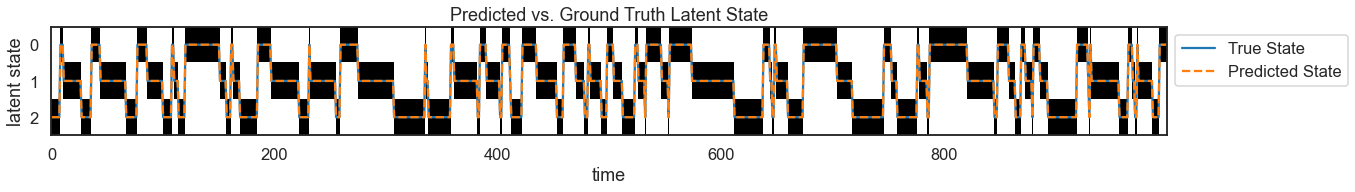

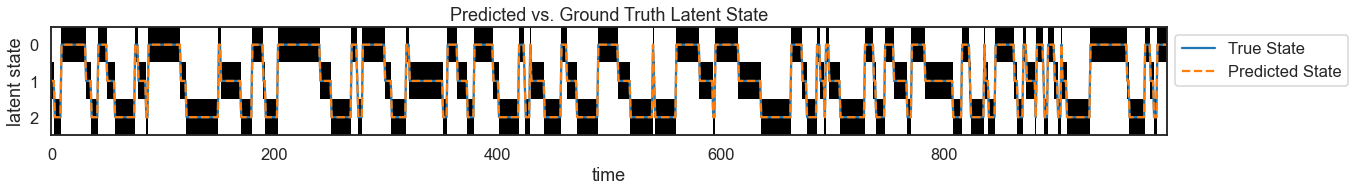

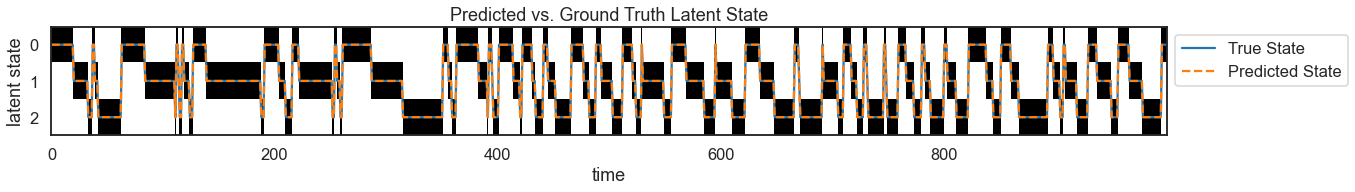

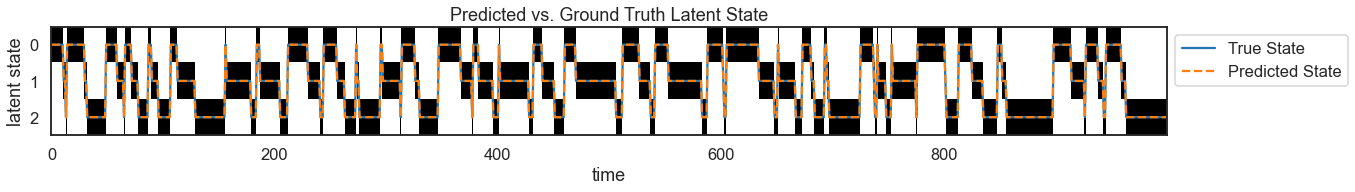

In [20]:
for trial_idx in range(5):
    posterior = fitted_hmm.e_step(data)
    Ez = posterior.expected_states[trial_idx]
    
    perm = find_permutation(states[trial_idx], np.argmax(Ez, axis=-1))
    
    plot_posterior_states(Ez, states[trial_idx], perm)

In [54]:
tfp.distributions.Bernoulli(0.5)

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[] event_shape=[] dtype=int32>